# Cubic spline through points

In this example, we will calculate a cubic spline interpolation (in the form of Pang Ch. 2) through some random points (that will change each time the program is run). The polynomial is given by:
$$p_i(x)=\alpha_i(x-x_i)^3+\beta_i(x-x_{i+1})+\gamma_i(x-x_i)^3+\eta_i(x-x_{i+1}) $$
where
$$\alpha_i=\frac{p^{\prime\prime}_{i+1}}{6\Delta x}, \; \; \beta_i=-\frac{p^{\prime\prime}_{i}}{6\Delta x}, \; \; \gamma_i=\frac{-p^{\prime\prime}_{i+1}\Delta x^2 +6f_{i+1}}{6\Delta x}, \; \; \eta_i=\frac{p^{\prime\prime}_{i}\Delta x^2 -6f_{i}}{6\Delta x}$$
As discussed in class, the main task is to solve the coupled set of linear equations
$$p^{\prime\prime}_{i-1}\Delta x +4 p^{\prime\prime}_i\Delta x + p^{\prime\prime}_{i+1}\Delta x = \frac{6}{\Delta x}(f_{i-1}-2f_i+f_{i+1})$$
for the interior points. For the end points, we will use "natural" boundary conditions: $p_0^{\prime\prime}=0, \;
p_n^{\prime\prime}=0$. This system can be written in the form of a tridiagonal matrix:
$$\begin{pmatrix}
4 \Delta x & \Delta x &&&& \\
\Delta x & 4 \Delta x &\Delta x &&& \\
&\Delta x & 4 \Delta x &\Delta x && \\
&&\ddots & \ddots & \ddots & \\
%&&&\Delta x & 4 \Delta x &\Delta x & \\
&&&\Delta x & 4 \Delta x &\Delta x  \\
&&&&\Delta x & 4 \Delta x \\
\end{pmatrix}
%
\begin{pmatrix}
p_1^{\prime\prime}\\
p_2^{\prime\prime}\\
p_3^{\prime\prime} \\
\vdots \\
p_{n-2}^{\prime\prime} \\
p_{n-1}^{\prime\prime}
\end{pmatrix}
%
=
%
\frac{6}{\Delta x}\begin{pmatrix}
f_0-2f_1+f_2\\
f_1-2f_2+f_3\\
f_2-2f_3+f_4\\
\vdots \\
f_{n-3}-2f_{n-2}+f_{n-1}\\
f_{n-2}-2f_{n-1}+f_{n}\\
\end{pmatrix}$$
which we will write as $\textbf{b}\cdot\textbf{p}=\textbf{f}$ for the code below.

*Note that the many of the cells in this notebook depend on previous ones, so you should execute them in order, at least the first time through*

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import linalg
from scipy import interpolate

class SplineInterp:
    ''' Class to do the spline interpolation for some points x and f, 
    assuming that they are equally spaced'''
    
    def __init__(self,x,f):
        self.x=x
        self.f=f
        self.dx=x[1]-x[0]
        self.nPoints=len(self.x)
        
        self.pDbPrime=self.solve_coeffs()
        self.cubicPolys=self.get_cubic_curves()
        
    def solve_coeffs(self):
        '''Solve for the coefficients'''
        
        # Note, n-1 unkowns neglecting the two endpoints
        n=self.nPoints-1
        
        # RHS of matrix equation above:
        fArray=np.zeros(n+1)
        fArray[1:n]=(6.0/self.dx)*(self.f[0:n-1]-2.0*self.f[1:n]+self.f[2:n+1])
        fArray=fArray[1:n] # Just get the interior points
        
        # Now assemble the tridiagonal matrix B as three arrays:
        # bUpper, bLower, bDiag for upper, lower, and diagonal elements
        bUpper=np.ones(n-1)*self.dx
        bUpper[0]=0.0
        
        bDiag=np.ones(n-1)*4.0*self.dx
        
        bLower=np.ones(n-1)*self.dx
        bLower[n-2]=0.0
        
        bMatrix=np.matrix([bUpper,bDiag,bLower])
        
        # Now we use scipy library banded solver. (1,1) means one
        # upper and one lower band around the diagonal
        pSolve=linalg.solve_banded((1,1),bMatrix,fArray)
        
        # Finally, apply natural boundarty conditions by inserting zeros before and after:
        pDbPrime=np.insert(pSolve,0,0)
        pDbPrime=np.insert(pDbPrime,n,0)
        
        return pDbPrime
    
    
    def get_cubic_curves(self):
        ''' get the cubic spline interpolation curves'''
        
        cubicPolys=[]
        # Loop through the segments
        for i in range(0,self.nPoints-1):
        
            x0=self.x[i]
            x1=self.x[i+1]
            f0=self.f[i]
            f1=self.f[i+1]
            dx=self.dx
            
            # Generate some points for plotting
            xPoints=np.linspace(x0,x1,100)
            
            # Now calculate the coefficients of the cubic spline ploynomial
            alphaI=self.pDbPrime[i+1]/(6.0*dx)
            betaI=-self.pDbPrime[i]/(6.0*dx)
            gammaI=(-self.pDbPrime[i+1]*dx**2+6.0*f1)/(6.0*dx)
            etaI=(self.pDbPrime[i]*dx**2-6.0*f0)/(6.0*dx)
            
            # And construct the polynomial
            cubicPoly=np.zeros((100,2))
            cubicPoly[:,0]=xPoints
            cubicPoly[:,1]=alphaI*(xPoints-x0)**3+betaI*(xPoints-x1)**3 \
                                +gammaI*(xPoints-x0)+etaI*(xPoints-x1)
            
            cubicPolys.append(cubicPoly)
            
        return cubicPolys
            
    

## Quick test

Lets test out our code on the points used to generate the example in the Lecture 5 slides:

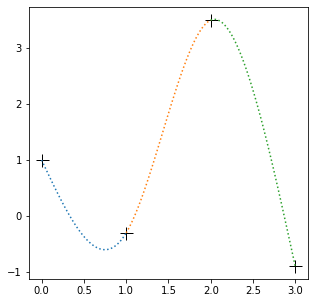

In [7]:
x=np.array([0,1,2,3])
f=np.array([1,-0.3,3.5,-0.9])

testInterp=SplineInterp(x,f)

# Now lets plot
fig1,ax1=plt.subplots(figsize=(5,5))

ax1.plot(x,f,'k+',markersize=13)
for i in range(0,testInterp.nPoints-1):
    
    ax1.plot(testInterp.cubicPolys[i][:,0],testInterp.cubicPolys[i][:,1],':')
    
plt.savefig('cubic_example.pdf',bbox_inches='tight')
plt.show()

# Random numbers

Now lets test with some random numbers on an interval.

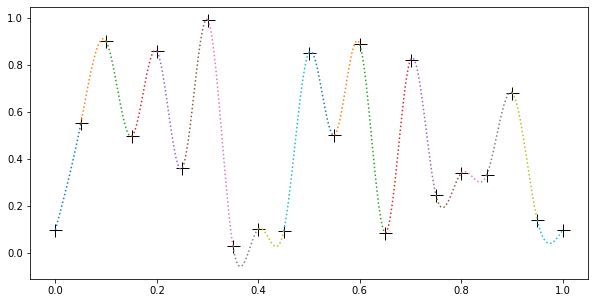

In [10]:
numIntervals=20
xMin=0.0
xMax=1.0

x=np.linspace(xMin,xMax,numIntervals+1)
f=np.random.rand(numIntervals+1)

# Make sure the first and last points are the same so we can use 
# scipy spline with periodic boundary conditions in cells below
f[-1]=f[0]

randomInterp=SplineInterp(x,f)

# Now lets plot
fig2,ax2=plt.subplots(figsize=(10,5))

ax2.plot(x,f,'k+',markersize=13)
for i in range(0,randomInterp.nPoints-1):
    
    ax2.plot(randomInterp.cubicPolys[i][:,0],randomInterp.cubicPolys[i][:,1],':')
    
    

plt.savefig('random_interp.pdf',bbox_inches='tight')
plt.show()

# Comparing boundary condtions using scipy

Lets use our interpolation of random data to compare to the scipy implementation of the cubic spline. We can choose different boundary conditions with the scipy implementation

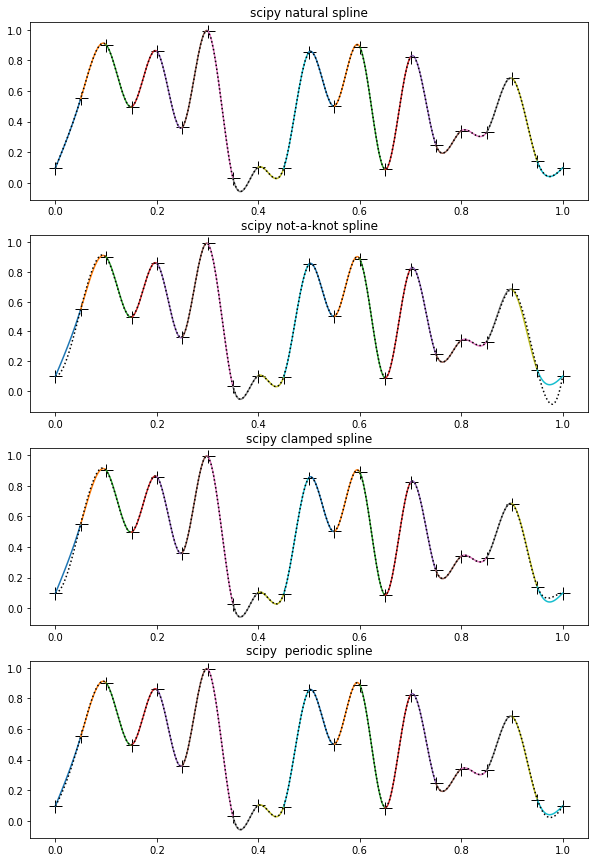

In [11]:
# We will use the x, f, and randomInterp from the previous cell

fig3,(ax31,ax32,ax33,ax34)=plt.subplots(4,1,figsize=(10,15))
axes=[ax31,ax32,ax33,ax34]

[axis.plot(x,f,'k+',markersize=13) for axis in axes]

for i in range(0,randomInterp.nPoints-1):
    
    for axis in axes:
        axis.plot(randomInterp.cubicPolys[i][:,0],randomInterp.cubicPolys[i][:,1],'-')

# Now lets compare to scipy for more details, see:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html
# and:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PPoly.html#scipy.interpolate.PPoly

xPoints=np.linspace(xMin,xMax,200)

# Natural
spInterpNatural=interpolate.CubicSpline(x,f,bc_type='natural')
ax31.plot(xPoints,spInterpNatural(xPoints),':k')
ax31.set_title("scipy natural spline")

# First and second segment at a curve end are the same polynomial
spInterpKnot=interpolate.CubicSpline(x,f,bc_type='not-a-knot')
ax32.plot(xPoints,spInterpKnot(xPoints),':k')
ax32.set_title("scipy not-a-knot spline")

# First derivative at curves ends are zero 
spInterpClamped=interpolate.CubicSpline(x,f,bc_type='clamped')
ax33.plot(xPoints,spInterpClamped(xPoints),':k')
ax33.set_title("scipy clamped spline")

# First and last points have same derivatives 
spInterpPeriodic=interpolate.CubicSpline(x,f,bc_type='periodic')
ax34.plot(xPoints,spInterpPeriodic(xPoints),':k')
ax34.set_title("scipy  periodic spline")

plt.savefig('scipy_comp.pdf',bbox_inches='tight')
plt.show()

# Derivatives of the cubic spline

The object returned by the scipy class contains the derivatives of the function. We can see that the first derivative looks good, the second derivative is less accurate but continuous, and the third derivative is, in general, not continuous.

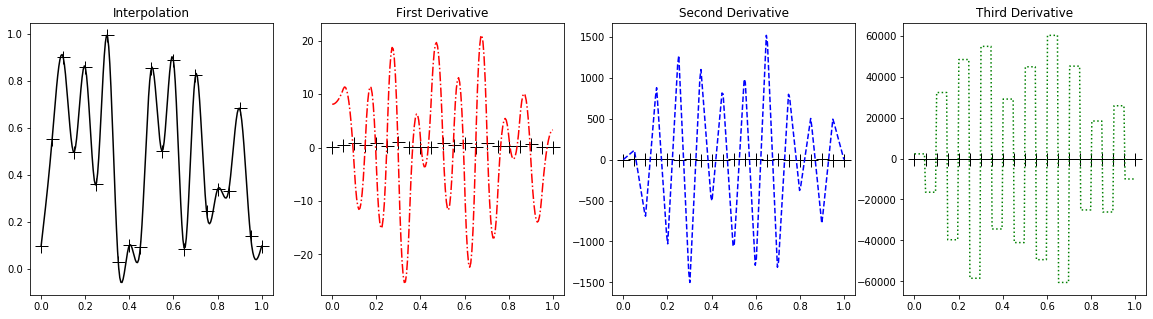

In [12]:
fig4,(ax41,ax42,ax43,ax44)=plt.subplots(1,4,figsize=(20,5))

axes=[ax41,ax42,ax43,ax44]
[axis.plot(x,f,'k+',markersize=13) for axis in axes]

ax41.plot(xPoints,spInterpNatural(xPoints),'-k')
ax41.set_title('Interpolation')

ax42.plot(xPoints,spInterpNatural(xPoints,1),'-.r')
ax42.set_title('First Derivative')

ax43.plot(xPoints,spInterpNatural(xPoints,2),'--b')
ax43.set_title('Second Derivative')

ax44.plot(xPoints,spInterpNatural(xPoints,3),':g')
ax44.set_title('Third Derivative')

plt.savefig('scipy_interp_deriv.pdf',bbox_inches='tight')
plt.show()